In [1]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from memory_reduction import reduce_memory_usage

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

from window_data import *

import os, errno
import sys
from tqdm import trange


import warnings
warnings.filterwarnings('ignore')

### Pre Processing & Dataset Preparation

#### GPU use
Emply GPU to accelerate the training of the deep learning model.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load and Clean Data

Data is stored in csv files. We will only consider traces where Csv_breath_hold and Data_breath_hold differs by fewer than 2 seconds

In [3]:
breath_df = pd.read_pickle('breath_df')
under2 = breath_df[abs(breath_df['Csv_breath_holds']\
                       -breath_df['Data_breath_holds'])<=2].reset_index()

In [4]:
under2.head()

,index,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,0,"[0.1319, 0.1363, 0.1408, 0.1452, 0.1497, 0.154...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,1,"[0.4727, 0.4687, 0.4646, 0.4605, 0.4563, 0.452...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"
2,3,"[0.0982, 0.0966, 0.095, 0.0934, 0.0919, 0.0904...",30.85,31.84,"[0.0013, 0.0027, 0.0034, 0.0041, 0.005, 0.006,...","[2573, 2574, 2575, 2576, 2577, 2578, 2579, 258...","(2573, 5756)"
3,4,"[0.0117, 0.0109, 0.0102, 0.0095, 0.0089, 0.008...",32.12,32.53,"[0.0012, 0.0015, 0.0019, 0.0023, 0.0029, 0.003...","[2520, 2521, 2522, 2523, 2524, 2525, 2526, 252...","(2520, 5772)"
4,5,"[0.1155, 0.1195, 0.1235, 0.1276, 0.1317, 0.135...",30.88,31.02,"[0.0008, 0.0011, 0.0014, 0.0018, 0.0023, 0.002...","[2683, 2684, 2685, 2686, 2687, 2688, 2689, 269...","(2683, 5784)"


In [5]:
under2.shape

(4793, 7)

#### Only Consider Regular Breathing

In [6]:
under2['start_idx'] = \
            [bh_range[0] for bh_range in under2['bh_start_end']]

In [7]:
q25 = under2['Data_breath_holds'].quantile(.1)
q50 = under2['Data_breath_holds'].quantile(.5)
q75 = under2['Data_breath_holds'].quantile(.99)
print(q25, q50, q75)

19.814 32.4 60.9008


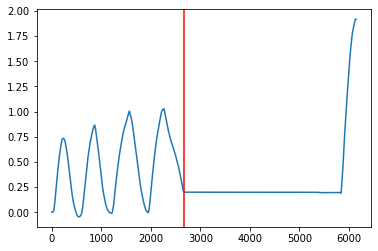

In [8]:
plt.plot(under2['Full_trace'][0])
plt.axvline(under2['start_idx'][0], c='red')
plt.show()

In [9]:
regular_breathing = []
for i in range(len(under2)):
    bh_start = under2['start_idx'][i] # breath hold start
    trace = under2['Full_trace'][i] # full breathing trace
    regular_breathing.append(trace[:bh_start]) # only consider reg breathing
under2['regular_breathing'] = regular_breathing

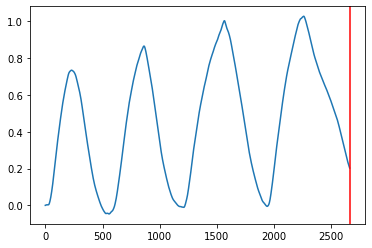

In [10]:
plt.plot(under2['regular_breathing'][0])
plt.axvline(under2['start_idx'][0], c='red')
plt.show()

#### Memory Usage 

In [11]:
under2 = reduce_memory_usage(under2)

Mem. usage decreased to  0.22 Mb from  0.33 Mb (33.3% reduction)


In [12]:
df = under2.copy()

In [13]:
df.head(2)

,index,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end,start_idx,regular_breathing
0,0,"[0.132, 0.1364, 0.1407, 0.1451, 0.1497, 0.1543...",31.296875,31.68750,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2660.0, 2662.0, 2664.0, 2664.0, 2664.0, 2666....","[2660.0, 5828.0]",2661,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023..."
1,1,"[0.4727, 0.4688, 0.4646, 0.4604, 0.4563, 0.452...",30.609375,31.40625,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386.0, 2388.0, 2388.0, 2388.0, 2390.0, 2392....","[2386.0, 5524.0]",2386,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002..."


#### Split Data

In [14]:
df = df.sample(frac=1).reset_index(drop=True)

In [15]:
train_size = int((len(df)) * 0.70)
valid_size = int((len(df))*.20)
test_size = int((len(df))*.10)
print("train size is:",train_size)
print("validation size is:",valid_size)
print("test size is:",test_size)

train size is: 3355
validation size is: 958
test size is: 479


In [16]:
train = df.iloc[0:train_size]
valid = df.iloc[train_size:train_size+valid_size]
test = df.iloc[train_size+valid_size:]
print("train data shape is:",train.shape)
print("validation data shape is:",valid.shape)
print("test data shape is:",test.shape)

train data shape is: (3355, 9)
validation data shape is: (958, 9)
test data shape is: (480, 9)


#### Normalize Data`

In [17]:
X_train = list(train['Trace'])
X_val = list(valid['Trace'])
X_test = list(test['Trace'])

In [22]:
scaler = MinMaxScaler() # creates the scaler, scales -1 to 1
scaler.fit(X_train)
x_train2 = scaler.transform(X_train)
x_val2 = scaler.transform(X_val)
x_test2 = scaler.transform(X_test)

#### Sliding Window

We wil use a sliding window of 100 points.
Our target(labels) is 10 points

In [23]:
num_outputs = 10

In [24]:
Train = create_windowed_data(n_steps=100, n_output=num_outputs, trace_column=x_train2)
Valid = create_windowed_data(n_steps=100, n_output=num_outputs, trace_column=x_val2)
Test = create_windowed_data(n_steps=100, n_output=num_outputs, trace_column=x_test2)

In [25]:
print(Train.shape)
print(Valid.shape)
print(Test.shape)

(43615, 3)
(12454, 3)
(6240, 3)


# 
create new ds to reconstruct trace

tune number of layers

#### Define Dataset

Convert data to tensors

In [26]:
def reshape_series(series):
    series = np.transpose(np.array(series))
    return series.reshape(series.shape[0],series.shape[1], 1)

x_train = reshape_series(list(Train['Trace']))
x_val = reshape_series(list(Valid['Trace']))
x_test = reshape_series(list(Test['Trace']))
y_train = reshape_series(list(Train['Next_pts']))
y_val = reshape_series(list(Valid['Next_pts']))
y_test = reshape_series(list(Test['Next_pts']))

In [27]:
#dataset
from torch.utils.data import Dataset

In [28]:
from torch.utils.data import Dataset

class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [29]:
train_dataset = timeseries(x_train, y_train)
valid_dataset = timeseries(x_val, y_val)
test_dataset = timeseries(x_test, y_test)

In [30]:
print ("train X shape is:",train_dataset.x.shape)
print ("train y shape is:",train_dataset.y.shape)

train X shape is: torch.Size([100, 43615, 1])
train y shape is: torch.Size([10, 43615, 1])


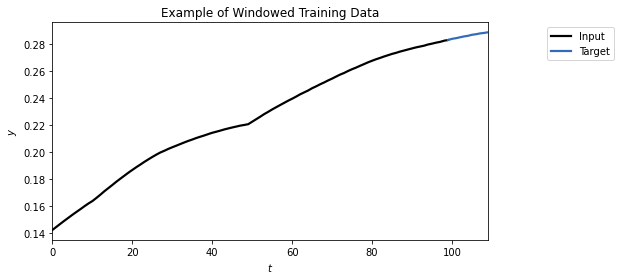

In [31]:
iw = 100
ow = 10 
# plot example of windowed data  
plt.figure(figsize = (9, 4)) 
plt.plot(np.arange(0, iw), x_train[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[x_train[-1, 0, 0]], y_train[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

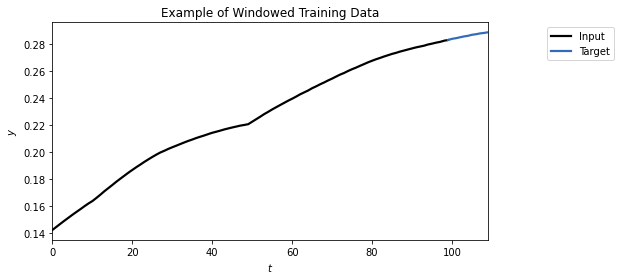

In [32]:
iw = 100
ow = 10 
# plot example of windowed data  
plt.figure(figsize = (9, 4)) 
plt.plot(np.arange(0, iw), x_train[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[x_train[-1, 0, 0]], y_train[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 

### Model Definition

#### Define LSTM Encoder and Decoder (Multistep Prediction)

Hui's paper:
- Num layers = 3
- Hidden units per layer = 15
- Learning rate = 0.001
- Epochs = 30
- Optimizer = Adam

In [33]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=3):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [34]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=3):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


#### Define Seq2Seq Model (Combining encoder and decoder)

In [35]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=3):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
    
    
    def val_metrics(self, input_tensor, target_tensor, batch_size=200, criterion=nn.MSELoss(), target_len=10):

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        val_batch_loss = 0.
        val_batch_mae = 0.
                
        for b in range(n_batches):
            input_batch = input_tensor[:, b: b + batch_size, :]
            target_batch = target_tensor[:, b: b + batch_size, :]

            # outputs tensor
            outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

            # initialize hidden state
            encoder_hidden = self.encoder.init_hidden(batch_size)
            encoder_output, encoder_hidden = self.encoder(input_batch)

            # decoder with teacher forcing
            decoder_input = input_batch[-1, :, :] 
            decoder_hidden = encoder_hidden

            for t in range(target_len): 
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                outputs[t] = decoder_output
                decoder_input = decoder_output

            # compute the loss 
            loss = criterion(outputs, target_batch)
            val_batch_loss += loss.item()
            
            # compute mae
            mae_func = nn.L1Loss()
            mae = mae_func(outputs, target_batch)
            val_batch_mae += mae.item()
        
        # loss for epoch 
        val_batch_loss /= n_batches 
        val_batch_mae /= n_batches
        
        return val_batch_loss, val_batch_mae
        
    
    def train_model(self, input_tensor, target_tensor, input_val, target_val, n_epochs, target_len,batch_size=200,learning_rate = 0.01, criterion = nn.MSELoss()):
        train_losses = np.full(n_epochs, np.nan)
        train_maes = np.full(n_epochs, np.nan)
        val_losses = np.full(n_epochs, np.nan)
        val_maes = np.full(n_epochs, np.nan)
        
        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = criterion

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                train_batch_loss = 0.
                train_batch_mae = 0.
                #val_batch_loss = 0.
                #
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    train_batch_loss += loss.item()
                    
                    # mae
                    mae_func = nn.L1Loss()
                    mae = mae_func(outputs, target_batch)
                    train_batch_mae += mae.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()
                    
            
                # loss for epoch 
                train_batch_loss /= n_batches 
                train_batch_mae /= n_batches
                train_losses[it] = train_batch_loss
                train_maes[it] = train_batch_mae
                
                ### Compute validation metrics ###
                val_metrics = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)
                val_batch_mae = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)[1]
                valid_batch_loss = self.val_metrics(input_val, target_val, batch_size=batch_size, criterion = criterion, target_len=10)[0]
                val_losses[it] = valid_batch_loss
                val_maes[it] = val_batch_mae


                # progress bar 
                tr.set_postfix(validation_MSE="{0:.3f}".format(valid_batch_loss), training_MSE = "{0:.3f}".format(train_batch_loss))
                
                
        losses = {"Train":train_losses, "Val":val_losses, "Train_mae":train_maes, "Val_mae":val_maes}
        return losses
    

    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


#### Initialize model and train

In [37]:
# model = lstm_seq2seq(input_size=1, hidden_size=15)
# losses = model.train_model(train_dataset.x, train_dataset.y,\
#                          valid_dataset.x, valid_dataset.y, \
#                          n_epochs = 30, target_len = num_outputs,\
#                          learning_rate = 0.001,\
#                          criterion = nn.MSELoss())
# torch.save(model, 'best_model2')

In [38]:
model = lstm_seq2seq(input_size=1, hidden_size=15)
model = torch.load('best_model2')

In [39]:
# losses2 = model.train_model(train_dataset.x, train_dataset.y,\
#                                                  valid_dataset.x, valid_dataset.y, \
#                                                  n_epochs = 30, target_len = num_outputs,\
#                                                  learning_rate = 0.0001,\
#                                                  criterion = nn.MSELoss())

### Tune Model

In [ ]:
num_layers = [1,2,3,5,10]

In [ ]:
for nl in num_layers:
model = lstm_seq2seq(input_size=1, hidden_size=15)
losses = model.train_model(train_dataset.x, train_dataset.y,\
                                                 valid_dataset.x, valid_dataset.y, \
                                                 n_epochs = 30, target_len = num_outputs,\
                                                 learning_rate = 0.001,\
                                                 criterion = nn.MSELoss())

### Plots

#### Loss Plots

In [68]:
# fig, ax = plt.subplots(2,2,figsize=(20,12))
# ax[0,0].plot(losses['Train'], color='teal')
# ax[0,0].set_title('Train MSE')
# ax[0,0].set_xlabel('Epochs')

# ax[0,1].plot(losses['Train_mae'], color='orange')
# ax[0,1].set_title('Train MAE')
# ax[0,1].set_xlabel('Epochs')

# ax[1,0].plot(losses['Val'], color='teal')
# ax[1,0].set_title('Validation MSE')
# ax[1,0].set_xlabel('Epochs')

# ax[1,1].plot(losses['Val_mae'], color='orange')
# ax[1,1].set_title('Validation MAE')
# ax[1,1].set_xlabel('Epochs')

In [40]:
test_mse, test_mae = model.val_metrics(test_dataset.x, test_dataset.y)
print('Test MSE Loss:', test_mse, '\nTest MAE Loss:', test_mae)

Test MSE Loss: 0.00011117297371158437 
Test MAE Loss: 0.004008297538084369


#### Plot test set predictions

In [41]:
def plot_test_preds(idx):
    iw = 100
    ow = 10 
    # plot example of windowed data  
    plt.figure(figsize = (9, 4)) 
    plt.plot(np.arange(0, iw), test_dataset.x[:, idx], 'k', linewidth = 2.2, label = 'Input')
    plt.plot(np.arange(iw - 1, iw + ow), \
             np.concatenate([test_dataset.x[-1, idx].detach().numpy(), test_dataset.y[:,idx].detach().numpy().reshape(-1)]),\
             color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')

    plt.plot(np.arange(iw - 1, iw + ow), \
             np.concatenate([test_dataset.x[-1, idx].detach().numpy(), model.predict(test_dataset.x[:, idx], 10).reshape(-1)]),\
             color = 'red', linewidth = 2.2, label = 'Prediction')


    plt.xlim([0, iw + ow - 1])
    plt.xlabel(r'$t$')
    plt.ylabel(r'$y$')
    plt.title('Prediction Example')
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.tight_layout() 

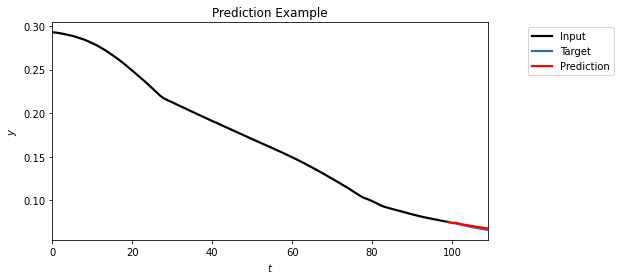

In [42]:
plot_test_preds(1)

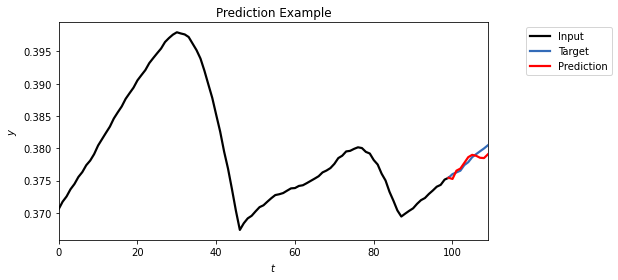

In [43]:
plot_test_preds(102)

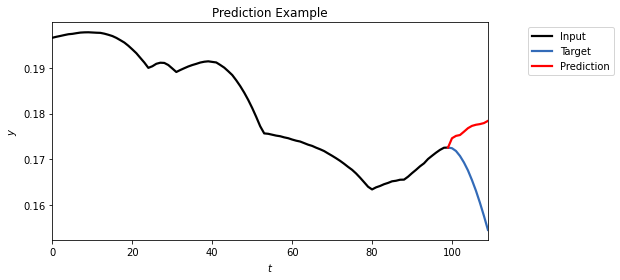

In [44]:
plot_test_preds(140)

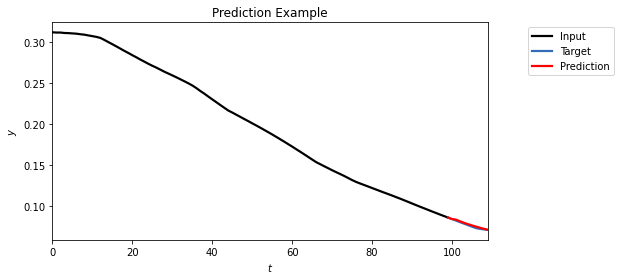

In [45]:
plot_test_preds(3241)

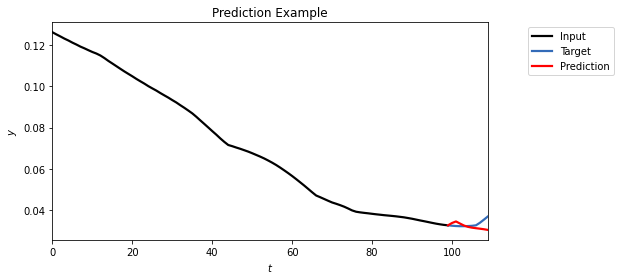

In [46]:
plot_test_preds(4567)

#### Reconstruct Traces

In [47]:
def sliding_split_trace(sequence, n_steps, n_output):
    X, y = list(), list()
    
    i = 0
    while i < len(sequence)-n_output:
        end_ix = i + n_steps
        
        # check if we are beyond the sequence
        if end_ix > len(sequence)-n_output:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+n_output]
        X.append(seq_x)
        y.append(seq_y)
        
        i += n_output
        
    return np.array(X), np.array(y)

In [48]:
traces = []
next_pt = []
trace_num = []
i = 0
for row in test['Trace']:
    Xs, ys = sliding_split_trace(row, 100, num_outputs)
    traces.append(Xs)
    next_pt.append(ys)
    trace_num.append(np.ones(len(Xs), dtype='int64')*i)
    i += 1

In [49]:
traces2 = [np.array(x, dtype='float32') for sublist in traces for x in sublist]
next_pt2 = [x for sublist in next_pt for x in sublist]
trace_num2 = [i for row in trace_num for i in row]

In [50]:
test_df2 = pd.DataFrame({"Trace":traces2, "Next_pts": next_pt2, "Trace_num":trace_num2})

In [51]:
test_df2.head()

,Trace,Next_pts,Trace_num
0,"[0.27490234, 0.28051758, 0.28588867, 0.2912597...","[0.77, 0.7725, 0.775, 0.7773, 0.779, 0.7803, 0...",0
1,"[0.32983398, 0.33544922, 0.3413086, 0.34692383...","[0.781, 0.7793, 0.7773, 0.7744, 0.7715, 0.768,...",0
2,"[0.38842773, 0.3942871, 0.40039062, 0.40649414...","[0.744, 0.7383, 0.7314, 0.7246, 0.7173, 0.7095...",0
3,"[0.44921875, 0.45532227, 0.46118164, 0.4672851...","[0.6675, 0.6587, 0.65, 0.641, 0.6323, 0.6235, ...",0
4,"[0.5083008, 0.5136719, 0.51953125, 0.52490234,...","[0.5806, 0.5723, 0.564, 0.556, 0.548, 0.54, 0....",0


In [84]:
# normalize 

In [52]:
def reshape_series(series):
    series = np.transpose(np.array(series))
    return series.reshape(series.shape[0],series.shape[1], 1)


x_test2 = reshape_series(list(test_df2['Trace']))
y_test2 = reshape_series(list(test_df2['Next_pts']))

In [53]:
test_full_traces = test_df2.groupby('Trace_num')['Next_pts'].apply(list)

In [ ]:
scaler = MinMaxScaler() # creates the scaler, scales -1 to 1
scaler.fit(X_train)
x_train2 = scaler.transform(X_train)

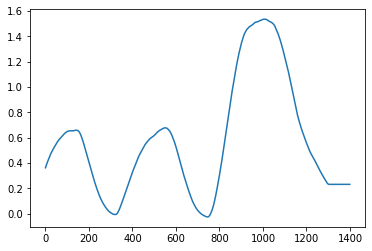

In [47]:
plt.plot([x for sublist in test_full_traces[10] for x in sublist])

In [65]:
test_dataset2 = timeseries(x_test2, y_test2)

In [66]:
def gather_preds(mymodel, dataset):
    preds = []
    for i in range(dataset.x.shape[1]):
        x_t = dataset.x[:, i, :]
        Y_pred = mymodel.predict(x_t, target_len = num_outputs)
        preds.append(Y_pred)
    return preds

In [67]:
#test_preds = gather_preds(model, test_dataset2)

In [69]:
#pred_df = pd.DataFrame({"test_preds":test_preds})

In [70]:
#pred_df.to_pickle('pred_df')

In [51]:
test_preds = pd.read_pickle('pred_df')

In [72]:
#test_preds.shape

In [54]:
test_preds.head()

,test_preds
0,"[[1.0285668], [1.0338018], [1.031386], [1.0268..."
1,"[[0.99820113], [1.001224], [0.9980939], [0.993..."
2,"[[0.966486], [0.967364], [0.9637016], [0.95964..."
3,"[[0.9354901], [0.93479496], [0.93112636], [0.9..."
4,"[[0.9102973], [0.90857357], [0.9051021], [0.90..."


In [57]:
test_df2['preds'] = test_preds

NameError: name 'test_preds' is not defined

In [74]:
test_df2.head()

,Trace,Next_pts,Trace_num,preds
0,"[1.1445312, 1.1503906, 1.15625, 1.1611328, 1.1...","[1.581, 1.586, 1.59, 1.595, 1.599, 1.604, 1.60...",0,"[[0.9921185], [0.9902699], [0.9829583], [0.970..."
1,"[1.1992188, 1.2041016, 1.2099609, 1.2148438, 1...","[1.623, 1.627, 1.632, 1.636, 1.64, 1.643, 1.64...",0,"[[0.9918963], [0.9901134], [0.9829452], [0.970..."
2,"[1.2490234, 1.2539062, 1.2587891, 1.2636719, 1...","[1.662, 1.665, 1.669, 1.673, 1.677, 1.68, 1.68...",0,"[[0.9916986], [0.98997116], [0.982931], [0.970..."
3,"[1.2929688, 1.296875, 1.3007812, 1.3046875, 1....","[1.696, 1.699, 1.703, 1.706, 1.709, 1.712, 1.7...",0,"[[0.9915192], [0.98983896], [0.98291576], [0.9..."
4,"[1.3310547, 1.3349609, 1.3388672, 1.3427734, 1...","[1.727, 1.7295, 1.732, 1.734, 1.737, 1.739, 1....",0,"[[0.9913633], [0.9897219], [0.9829004], [0.970..."


In [75]:
test_pred_trace = test_df2.groupby('Trace_num')['preds'].apply(list)

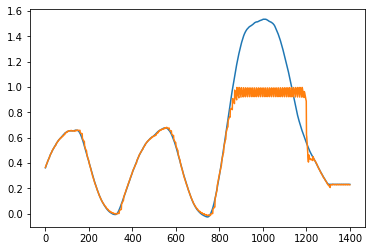

In [76]:
plt.plot([x for sublist in test_full_traces[10] for x in sublist])
plt.plot([x for sublist in test_pred_trace[10] for x in sublist], '-')
plt.show()

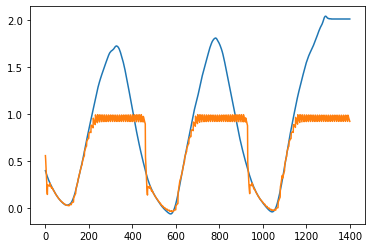

In [77]:
plt.plot([x for sublist in test_full_traces[350] for x in sublist])
plt.plot([x for sublist in test_pred_trace[350] for x in sublist], '-')
plt.show()

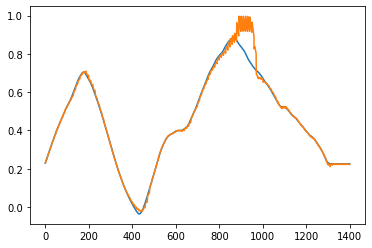

In [78]:
plt.plot([x for sublist in test_full_traces[450] for x in sublist])
plt.plot([x for sublist in test_pred_trace[450] for x in sublist], '-')
plt.show()

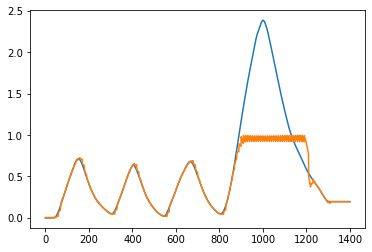

In [79]:
plt.plot([x for sublist in test_full_traces[90] for x in sublist])
plt.plot([x for sublist in test_pred_trace[90] for x in sublist], '-')
plt.show()

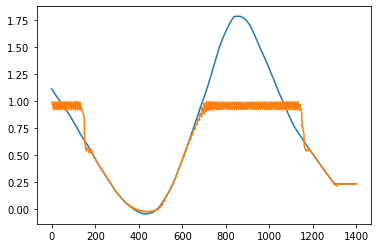

In [80]:
plt.plot([x for sublist in test_full_traces[333] for x in sublist])
plt.plot([x for sublist in test_pred_trace[333] for x in sublist], '-')
plt.show()

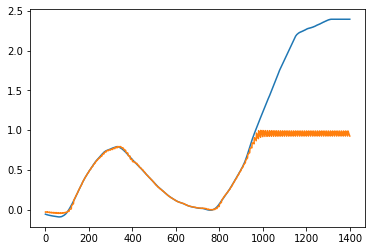

In [82]:
plt.plot([x for sublist in test_full_traces[234] for x in sublist])
plt.plot([x for sublist in test_pred_trace[234] for x in sublist], '-')
plt.show()

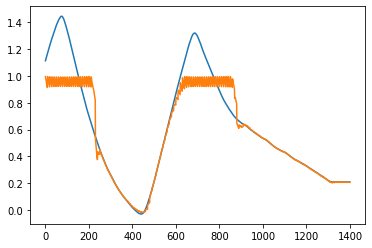

In [83]:
plt.plot([x for sublist in test_full_traces[198] for x in sublist])
plt.plot([x for sublist in test_pred_trace[198] for x in sublist], '-')
plt.show()